In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from scipy.spatial.distance import pdist
import torch.optim as optim
from matplotlib.lines import Line2D  # Import Line2D for custom legend
from torch.optim.lr_scheduler import ReduceLROnPlateau

import sys
import os
print("cwd: ", os.getcwd())  # Check the current working directory
print("sys path: ", sys.path)  
sys.path.append(os.getcwd())
print(os.getcwd() in sys.path)

from utils import *
# import my_utils
import importlib
from my_utils import my_test, evaluate_regression_model, plot_mollies

# plt.ion()
# plt.show(block=True)

# import sys
# print(sys.path)


cwd:  /Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/hw07
sys path:  ['/usr/local/Cellar/python@3.12/3.12.6/Frameworks/Python.framework/Versions/3.12/lib/python312.zip', '/usr/local/Cellar/python@3.12/3.12.6/Frameworks/Python.framework/Versions/3.12/lib/python3.12', '/usr/local/Cellar/python@3.12/3.12.6/Frameworks/Python.framework/Versions/3.12/lib/python3.12/lib-dynload', '', '/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages']
True


In [2]:
# # import importlib
# import my_utils
# # importlib.reload(my_utils)
# print(my_utils.__file__)
# # my_utils.my_test()
# from my_utils import my_test
# my_test()

In [3]:
import importlib
import my_utils
importlib.reload(my_utils)
my_utils
my_test()


TESTING!


'testing'

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
molecule = np.array(
    [
        [0.702581, 1.820873],
        [0.702581, 0.296325],
        [-0.702581, -0.296325],
        [-0.702581, -1.820873],
    ]
)
n_atoms = molecule.shape[0]
n_dimensions = molecule.shape[1]
n_samples = 5000
noise = np.random.normal(loc=0.0, scale=0.1, size=(n_samples, n_atoms, n_dimensions))
noised_molecules = np.array(molecule + noise)
flattened_coordinates = np.array([np.reshape(mol, (n_atoms*n_dimensions)) for mol in noised_molecules])
distances = np.array([pdist(mol) for mol in noised_molecules])
potentials = np.array([(1 / dist) for dist in distances])
total_energies = np.array([sum(potential) for potential in potentials])

In [5]:
all_coords, coords_train, coords_test = split_data(flattened_coordinates, total_energies, 0.8, DEVICE)
all_dists, dists_train, dists_test = split_data(distances, total_energies, 0.8, DEVICE)


coords_loader = DataLoader(coords_train, batch_size=16, shuffle=True)
dists_loader = DataLoader(dists_train, batch_size=16, shuffle=True)

coords_model = MLP([8, 128, 128, 128, 64, 32, 1]).to(DEVICE)
dists_model = MLP([6, 128, 128, 128, 64, 32, 1]).to(DEVICE)

coords_optimizer = torch.optim.Adam(coords_model.parameters())
dists_optimizer = torch.optim.Adam(dists_model.parameters())

coords_criterion = dists_criterion = torch.nn.MSELoss()

coords_losses = []
dists_losses = []

In [ ]:
EPOCHS = 100

for epoch in range(EPOCHS):
    coords_losses.append(train(coords_model, coords_loader, coords_optimizer, coords_criterion, DEVICE))
    dists_losses.append(train(dists_model, dists_loader, dists_optimizer, dists_criterion, DEVICE))
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Coords Loss: {coords_losses[-1]} Dists Loss: {dists_losses[-1]}")

/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 | Coords Loss: 0.6160406872853637 Dists Loss: 0.5830467757340521


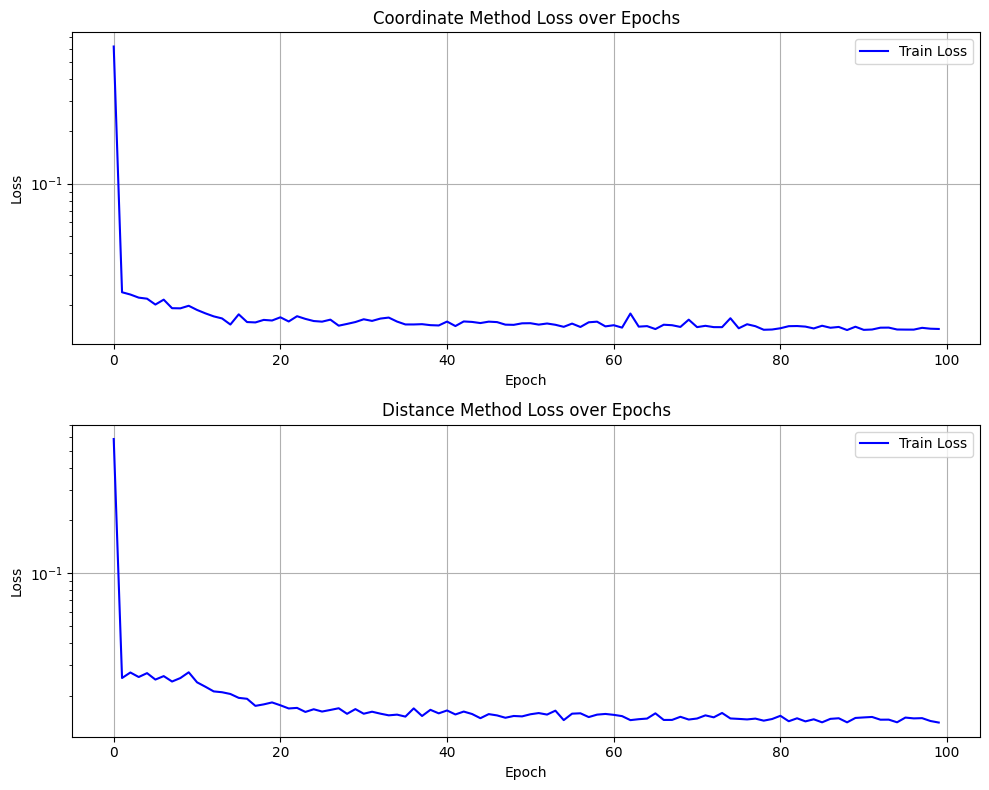

In [7]:
plt.figure(figsize=(10, 8))

# First subplot (top)
plt.subplot(2, 1, 1)  

# train loss
plt.plot(range(len(coords_losses)), coords_losses, label="Train Loss", color="blue")

# test loss
# plt.plot(range(len(coords_test_losses)), coords_test_losses, label="Test Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Coordinate Method Loss over Epochs")
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot

#train loss
plt.plot(range(len(dists_losses)), dists_losses, label="Train Loss", color="blue")

# test losses
# plt.plot(range(len(dists_losses)), dists_test_losses, label="Test Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Distance Method Loss over Epochs")
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.tight_layout()
plt.show()

TEST
hit plot


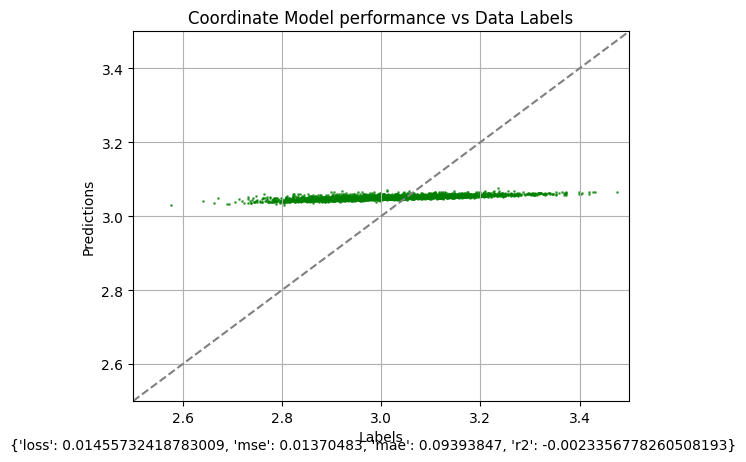

{'loss': 0.01455732418783009,
 'mse': 0.01370483,
 'mae': 0.09393847,
 'r2': -0.0023356778260508193}

In [8]:
evaluate_regression_model(coords_model, coords_loader, coords_criterion, device=DEVICE, plot=True, xlabel="Labels", ylabel="Predictions", title="Coordinate Model performance vs Data Labels")

TEST


/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


hit plot


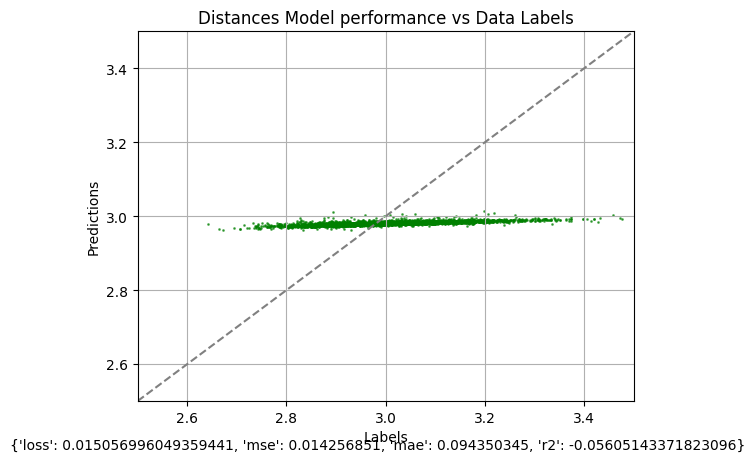

{'loss': 0.015056996049359441,
 'mse': 0.014256851,
 'mae': 0.094350345,
 'r2': -0.05605143371823096}

In [9]:
evaluate_regression_model(dists_model, dists_loader, dists_criterion, device=DEVICE, plot=True, xlabel="Labels", ylabel="Predictions", title="Distances Model performance vs Data Labels")

/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/hw07/my_utils.py:112: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


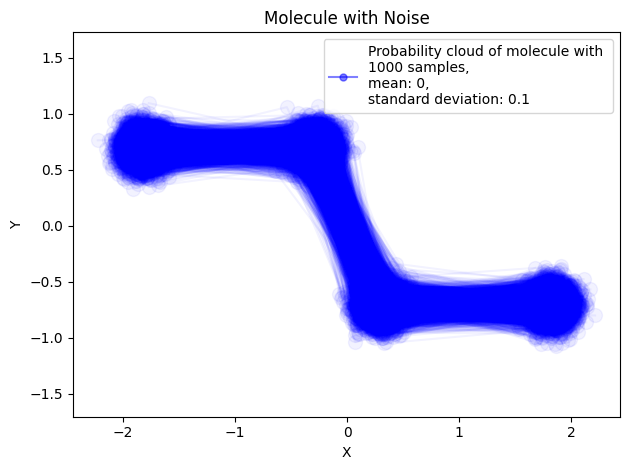

In [10]:
def rotate(vector, theta):
    """Rotates a two-dimensional vector by the angle theta."""
    rotMatrix = np.array(
        [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]
    )
    return np.matmul(rotMatrix, vector)

rotated_noised_molecules = [np.transpose(rotate(np.transpose(molly), np.pi / 2)) for molly in noised_molecules]
plot_mollies(rotated_noised_molecules, "Rotated Molecule with Noise")


In [11]:
flattened_rotated_coordinates = np.array([np.reshape(mol, (n_atoms*n_dimensions)) for mol in rotated_noised_molecules])
rotated_distances = np.array([pdist(mol) for mol in rotated_noised_molecules])
rotated_potentials = np.array([(1 / dist) for dist in rotated_distances])
rotated_total_energies = np.array([sum(potential) for potential in rotated_potentials])

all_coords, coords_train, coords_test = split_data(flattened_rotated_coordinates, rotated_total_energies, 0.8, DEVICE)
all_dists, dists_train, dists_test = split_data(rotated_distances, rotated_total_energies, 0.8, DEVICE)


rotated_coords_loader = DataLoader(rotated_noised_molecules, batch_size=16, shuffle=True)
rotated_dists_loader = DataLoader(dists_train, batch_size=16, shuffle=True)


evaluate_regression_model(coords_model, rotated_coords_loader, coords_criterion, DEVICE, plot=True, xlabel="Predicted potential", ylabel="Labeled Potential", title="Coordinate model on rotated data")
# print("Rotated distances model: ", evaluate_regression_model(dists_model, rotated_dists_loader, criterion))

# print("Permutated rotated coords model: ", evaluate_regression_model(coords_model, permutated_rotated_coords_loader, criterion))
# print("Permutated rotated distances model: ", evaluate_regression_model(dists_model, permutated_rotated_dists_loader, criterion))

TEST


ValueError: too many values to unpack (expected 2)

In [ ]:
# 2.3

augmented_coords1 = np.vstack((rotated_flattened_coordinates, flattened_coordinates))
permutated_coords_without_rotating = [np.reshape(permute_without_fixed_points(molly), (n_atoms*n_dimensions)) for molly in noised_molecules]
augmented_coords2 = np.vstack((flattened_coordinates, permutated_coords_without_rotating))

# print(augmented_coords1)
# print(augmented_coords2)

def get_dists_from_flattened(mol):
  x1, y1, x2, y2, x3, y3, x4, y4 = mol
  d12 = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** .5
  d13 = ((x1 - x3) ** 2 + (y1 - y3) ** 2) ** .5
  d14 = ((x1 - x4) ** 2 + (y1 - y4) ** 2) ** .5
  d23 = ((x2 - x3) ** 2 + (y2 - y3) ** 2) ** .5
  d24 = ((x2 - x4) ** 2 + (y2 - y4) ** 2) ** .5
  d34 = ((x3 - x4) ** 2 + (y3 - y4) ** 2) ** .5
  rtn = [d12, d13, d14, d23, d24, d34]
  return rtn


augmented_distances1 = [get_dists_from_flattened(mol) for mol in augmented_coords1]
augmented_potentials1 = [(1 / dist) for dist in augmented_coords1]
augmented_total_energies1 = np.array([sum(potential) for potential in augmented_potentials1])

augmented_distances2 = np.array([get_dists_from_flattened(mol) for mol in augmented_coords2])
augmented_potentials2 = [(1 / dist) for dist in augmented_coords2]
augmented_total_energies2 = np.array([sum(potential) for potential in augmented_potentials2])

train_fraction = .8
n_train = int(train_fraction * n_samples * 2)

ids = np.arange(n_samples * 2)
print(ids)
np.random.shuffle(ids)
ids_train, ids_test  = map(np.array, np.split(ids, [n_train]))
ids_train = np.array(ids_train)
ids_test = np.array(ids_test)

print(ids_train)
print(ids_test)

aug1_train_data = Data(augmented_coords1[ids_train], augmented_total_energies1[ids_train])
aug1_test_data = Data(augmented_coords1[ids_test], augmented_total_energies1[ids_test])
aug2_train_data = Data(augmented_coords2[ids_train], augmented_total_energies2[ids_train])
aug2_test_data = Data(augmented_coords2[ids_test], augmented_total_energies2[ids_test])

batch_size = 128
aug1_train_loader = DataLoader(aug1_train_data, 
                         batch_size=batch_size, 
                         shuffle=True)
aug1_test_loader = DataLoader(aug1_test_data, 
                         batch_size=batch_size, 
                         shuffle=True)

aug2_train_loader = DataLoader(aug2_train_data, 
                         batch_size=batch_size, 
                         shuffle=True)
aug2_test_loader = DataLoader(aug2_test_data, 
                         batch_size=batch_size, 
                         shuffle=True)

# coords_input_size = 8  # Example input size (number of features)
# dists_input_size = 6
# hidden_sizes = [128, 128, 128, 128, 128, 64, 64, 32]  # Number of neurons per hidden layer
# output_size = 1  # Single output (potential energy)

augmented_model1 = MLPPotentialEstimator(coords_input_size, hidden_sizes, output_size)
augmented_model2 = MLPPotentialEstimator(coords_input_size, hidden_sizes, output_size)


criterion = nn.MSELoss()
dists_criterion = nn.MSELoss()
augmented_optimizer1 = optim.SGD(augmented_model1.parameters(), lr=0.001)
augmented_optimizer2 = optim.SGD(augmented_model2.parameters(), lr=.001)
# scheduler = ReduceLROnPlateau(coords_optimizer, 'min', patience=5, factor=0.5, verbose=True)

# original_and_rotated_coords
